In [ ]:
import pandas as pd
import spacy
import scispacy
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import numpy as np


c:\Users\patto\Anaconda3\envs\AIinHealthcare\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

Load the NOTEVENTS, DIAGNOSES_ICD, and D_ICD_DIAGNOSES CSV files.

In [2]:
noteevents_df = pd.read_csv('./NOTEEVENTS.csv')
diagnoses_df = pd.read_csv('./DIAGNOSES_ICD.csv')
ICD9_df = pd.read_csv('./D_ICD_DIAGNOSES.csv')

C:\Users\patto\AppData\Local\Temp\ipykernel_12856\2969941984.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv('./NOTEEVENTS.csv')


### Clean Data & Extract Discharge Summaries

Filter out non-discharge summaries from NOTEVENTS.

In [ ]:
# Define a list of ICD9 codes to filter
icd_codes = ['5990']  # ICD Code for Severe Sepsis

# Filter to only include discharge summaries and select the relevant columns
filtered_notes = noteevents_df[noteevents_df['CATEGORY'] == 'Discharge summary'][['SUBJECT_ID', 'HADM_ID', 'TEXT']]
filtered_notes = filtered_notes.dropna()
#filter down to onnly the ICD9 codes we are interested in
filtered_diagnoses = diagnoses_df[diagnoses_df['ICD9_CODE'] == icd_codes[0]][['HADM_ID', 'ICD9_CODE']]
#print how many rows are in filtered diagnoses
print(filtered_diagnoses.shape[0])

6555


### Merge with Diagnoses & Filter by ICD Code

Merge the discharge summaries with the diagnoses data on `HADM_ID` and then filter for a specific ICD code (replace `'XXX'` with the ICD code of interest).

In [18]:
# Merge the notes with diagnoses on HADM_ID
merged_df = filtered_notes.merge(filtered_diagnoses, on='HADM_ID', how='inner')
#remove duplicated rows
merged_df = merged_df.drop_duplicates(subset='HADM_ID')
print('Number of filtered records:', merged_df.shape[0])
print(merged_df.head())


Number of filtered records: 6442
   SUBJECT_ID   HADM_ID                                               TEXT  \
0       28063  121936.0  Admission Date:  [**2125-2-9**]              D...   
1       22663  187885.0  Admission Date:  [**2165-9-23**]     Discharge...   
2       17483  189331.0  Admission Date:  [**2147-6-24**]     Discharge...   
3       22180  162436.0  Admission Date:  [**2134-2-16**]              ...   
4       75347  152030.0  Admission Date:  [**2174-5-3**]              D...   

  ICD9_CODE  
0      5990  
1      5990  
2      5990  
3      5990  
4      5990  


### Entity Extraction with Spacy

Use Spacy’s standard model to extract entities from the note text.

In [19]:
nlp = spacy.load("en_core_web_sm")

def process_text(text):
    """Processes text efficiently: extracts cleaned named entities while running nlp only once."""
    doc = nlp(text)  # Run NLP once

    # Extract entities and clean them in one go
    entities = set()  # Use a set to remove duplicates
    for ent in doc.ents:
        tokens = [token.text for token in ent if not token.is_stop and not token.is_punct and (token.is_alpha or token.is_digit)]
        cleaned_entity = ' '.join(tokens).strip()
        if cleaned_entity:  # Avoid empty strings
            entities.add(cleaned_entity)

    return list(entities)  # Return list format for compatibility

# Apply function to DataFrame (vectorized for efficiency)
merged_df['spacy_entities'] = merged_df['TEXT'].apply(process_text)


# Show a sample of the extracted entities
print(merged_df[['HADM_ID', 'spacy_entities']].head())

c:\Users\patto\Anaconda3\envs\AIinHealthcare\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


    HADM_ID                                     spacy_entities
0  121936.0  [ACE inhibitor, 5, 28, EMS, 1 gallon, NRB, 212...
1  187885.0  [96, 5, 12, 2165 9 28, 2165 9 23, CT, 3, days,...
2  189331.0  [805, Blood, Pentasa, NI, ICU, 2147 9 5, 1897,...
3  162436.0  [5, 1559, 13, TWI, Cap PO DAILY, CT, Losartan,...
4  152030.0  [64, Family History, 5, 13, 2174 5 3, Tablet P...


In [ ]:
#store new filtered dataframe in csv
merged_df.to_csv('NEWfiltered_sep_df.csv', index=False)

In [ ]:
merged_df = pd.read_csv('NEWfiltered_sep_df.csv')

### Word2Vec Embeddings for Spacy Entities

Train a Word2Vec model using the Spacy-extracted entities and compute embeddings.

In [ ]:
sep_corpus = []
for row in range(0, len(merged_df)):
    ent_str = []
    #combine all the entities into one string
    string = ' '.join(merged_df.iloc[row]['spacy_entities'])
    ents = nlp(string).ents
    for i in range(0, len(ents)):
        ent_str.append(ents[i].text)
    sep_corpus.append(list(ent_str))

#flatten corpus
flat_corpus = [word for sublist in sep_corpus for word in sublist]

# Train Word2Vec on the Spacy entities
model_spacy = Word2Vec(sep_corpus, min_count=40, vector_size=200, window=10, workers=4)

#print(merged_df[['HADM_ID', 'spacy_embeddings']].head())

### t-SNE Visualization for Spacy Embeddings

Flatten the embeddings and use t-SNE to visualize them.

In [23]:
def tsne_plot(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [24]:
import random
def random_words(corpus, num_words):
    return random.sample(corpus, num_words)

c:\Users\patto\Anaconda3\envs\AIinHealthcare\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


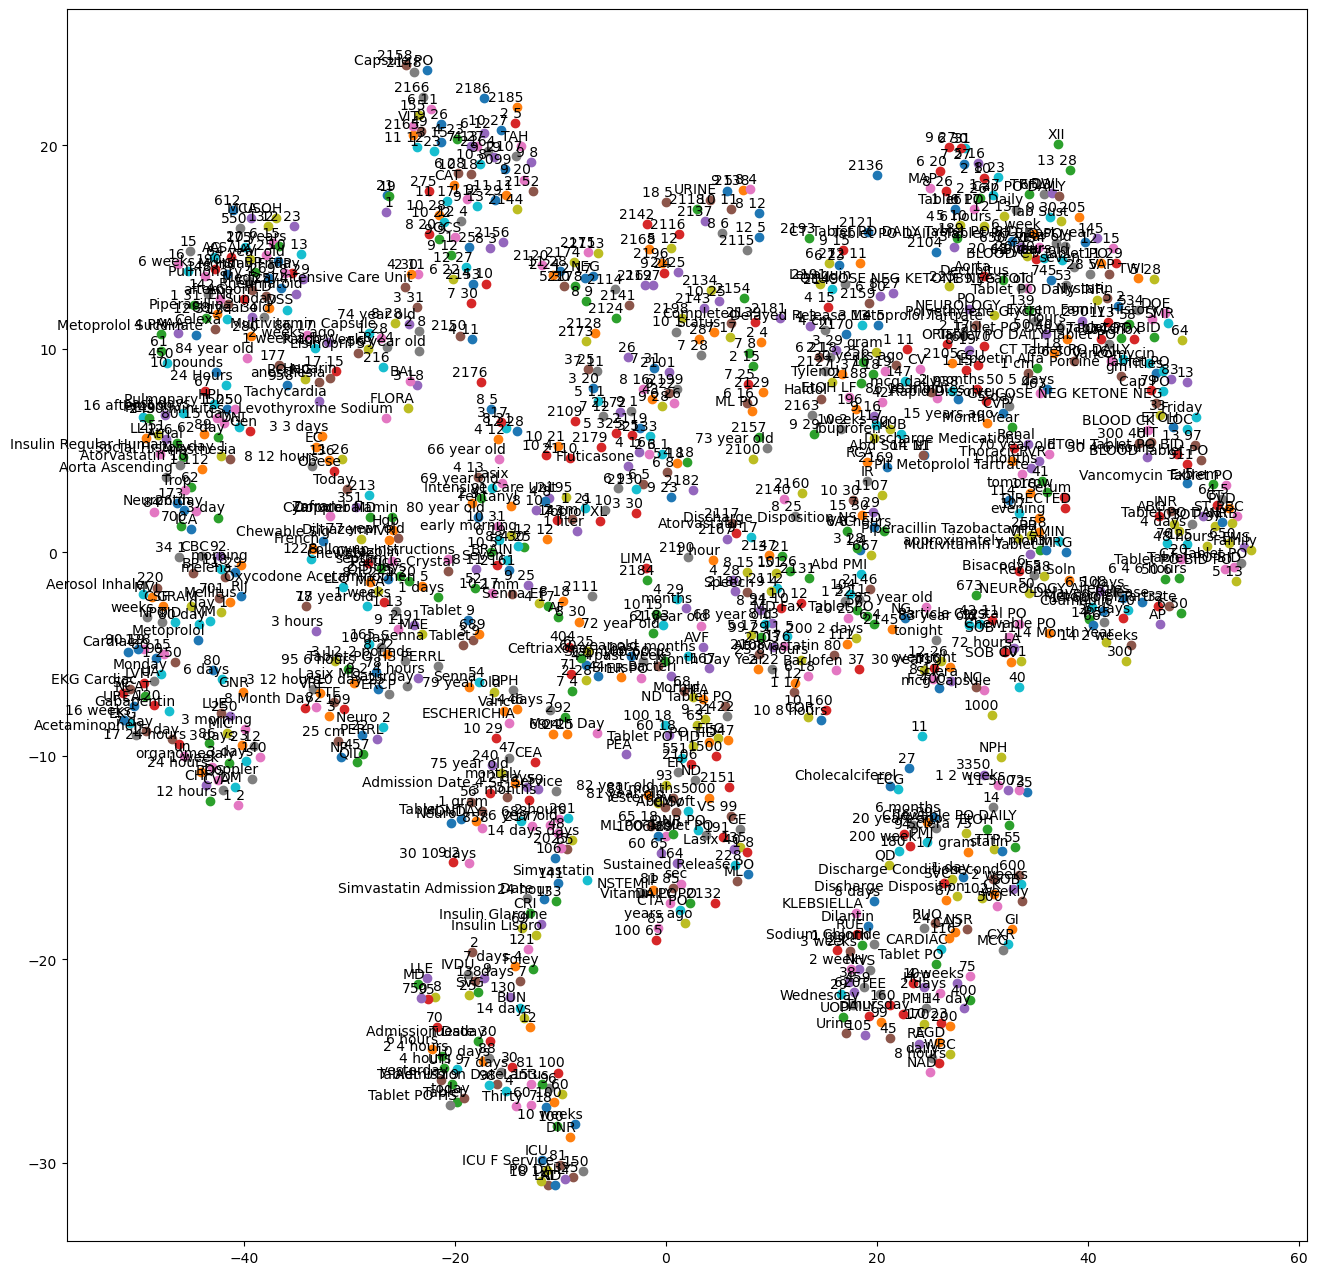

In [27]:
vocabs = model_spacy.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(model_spacy,new_v)